In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

In [2]:
DATA_PATH = Path("./data")
TRAIN_PATH = DATA_PATH / "train.csv"
TEST_PATH = DATA_PATH / "test.csv"
SAMPLE_SUBMISSION_PATH = DATA_PATH / "gender_submission.csv"

In [3]:
train_df = pd.read_csv(TRAIN_PATH)

print(len(train_df))
train_df.head()

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df = pd.read_csv(TEST_PATH)
test_ids = test_df["PassengerId"]


print(len(test_df))
test_df.head()

418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## EDA

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
men = train_df.loc[train_df.Sex == "male"]["Survived"]
rate_men = sum(men)/len(men)

women = train_df.loc[train_df.Sex == "female"]["Survived"]
rate_women = sum(women)/len(women)

print("% of men who survived:", rate_men)
print("% of women who survived:", rate_women)

% of men who survived: 0.18890814558058924
% of women who survived: 0.7420382165605095


In [9]:
# Name
pre_names = train_df["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0].unique()

pre_names

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [10]:
# Cabin
print(train_df.loc[train_df["Cabin"].notna()]["Cabin"][:10])
print("\n", train_df["Cabin"].str.slice(0,1).unique())
print("\n", train_df["Cabin"].str.slice(0,1).value_counts())
print("\n", "Nan values:", train_df["Cabin"].isna().sum(), "out of", len(train_df), "total rows")

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object

 [nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']

 C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

 Nan values: 687 out of 891 total rows


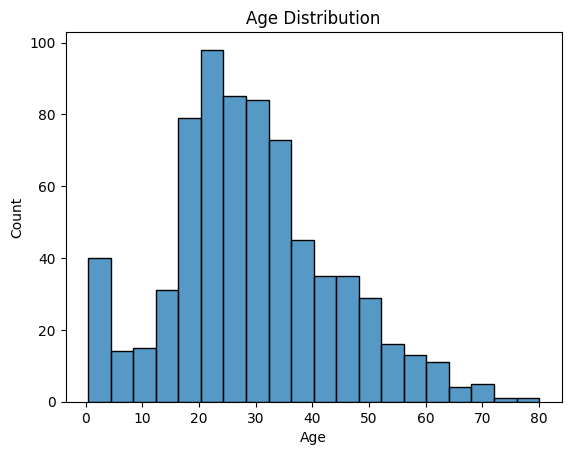

In [11]:
# Create histogram of age distribution
sns.histplot(train_df['Age'], bins=20, kde=False)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

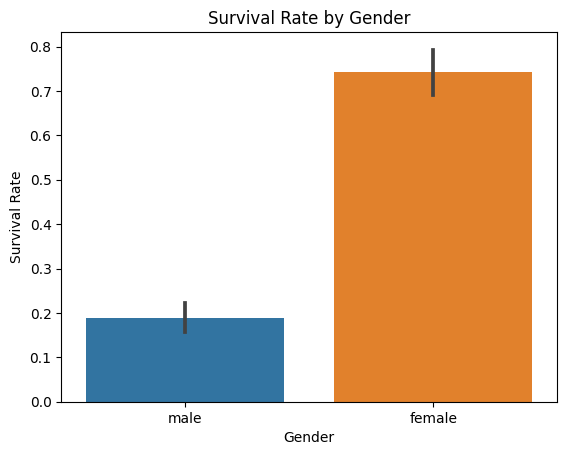

In [12]:
# Create bar plot of survival rate by gender
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Gender')
plt.show()

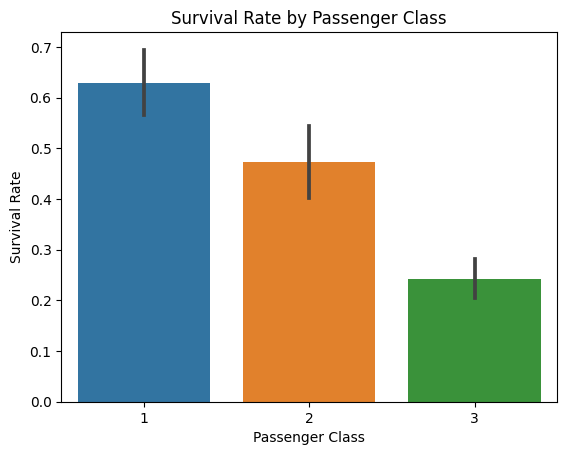

In [13]:
# Create bar plot of survival rate by passenger class
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Passenger Class')
plt.show()

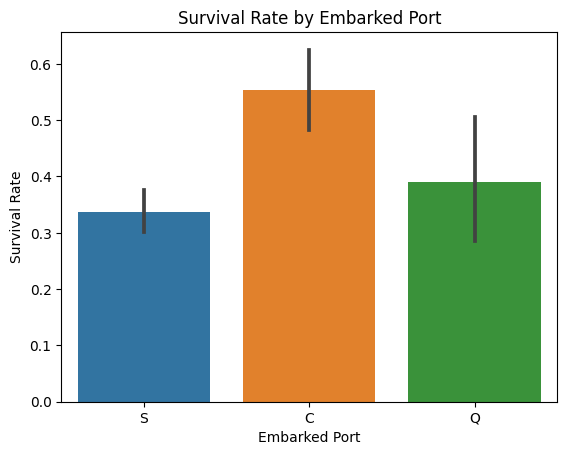

In [14]:
# Create bar plot of survival rate by embarked port
sns.barplot(x='Embarked', y='Survived', data=train_df)
plt.xlabel('Embarked Port')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Embarked Port')
plt.show()

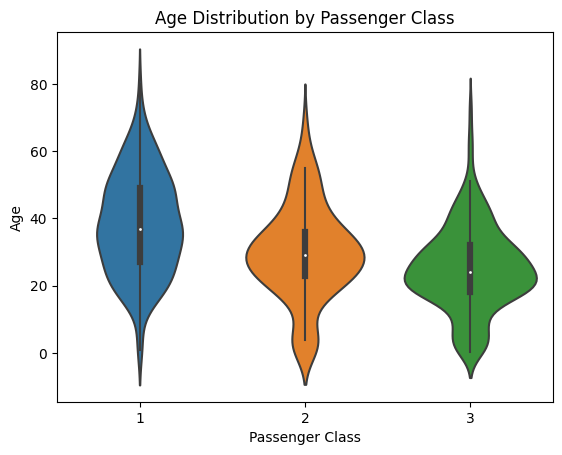

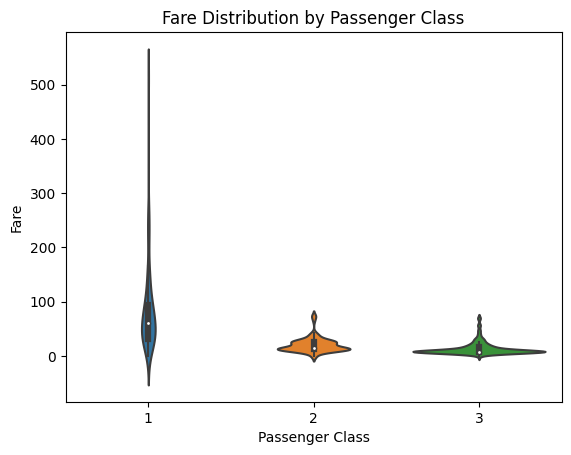

In [15]:
# Create violin plot of age and fare distribution by passenger class
sns.violinplot(x='Pclass', y='Age', data=train_df)
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.title('Age Distribution by Passenger Class')
plt.show()

sns.violinplot(x='Pclass', y='Fare', data=train_df)
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.title('Fare Distribution by Passenger Class')
plt.show()

C:\Users\Enric\AppData\Local\Temp\ipykernel_25676\1263200519.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


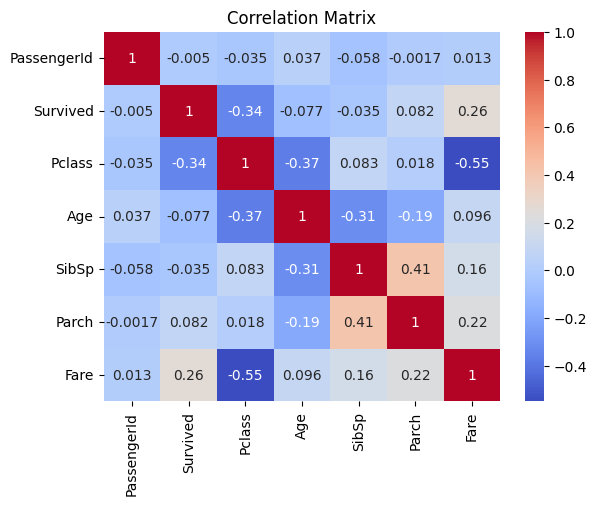

In [16]:
# Create correlation matrix
corr = train_df.corr()

# Create heatmap of correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [17]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Load Titanic dataset
#train_df = pd.read_csv('train.csv')

# Visualize survival rate by sex
survival_rate_by_sex = train_df.groupby('Sex')['Survived'].mean().reset_index()
fig1 = px.bar(survival_rate_by_sex, x='Sex', y='Survived', color='Sex', labels={'Survived': 'Survival Rate'})
fig1.update_layout(title='Survival Rate by Sex', yaxis_tickformat='%')

# Visualize survival rate by passenger class and embarkation port
survival_rate_by_class_port = train_df.groupby(['Pclass', 'Embarked'])['Survived'].mean().reset_index()
fig2 = px.scatter(survival_rate_by_class_port, x='Pclass', y='Survived', color='Embarked',
                   size='Survived', labels={'Survived': 'Survival Rate'})
fig2.update_layout(title='Survival Rate by Passenger Class and Embarkation Port', yaxis_tickformat='%')

# Visualize age distribution by survival and passenger class
age_distribution = train_df[['Age', 'Pclass', 'Survived']].dropna()
fig3 = make_subplots(rows=1, cols=2, subplot_titles=['Age Distribution of Survivors', 'Age Distribution of Non-Survivors'])
fig3.add_trace(go.Histogram(x=age_distribution[age_distribution['Survived'] == 1]['Age'], 
                             nbinsx=20, name='Survived'), row=1, col=1)
fig3.add_trace(go.Histogram(x=age_distribution[age_distribution['Survived'] == 0]['Age'], 
                             nbinsx=20, name='Not Survived'), row=1, col=2)
fig3.update_layout(title='Age Distribution by Survival and Passenger Class')

# Visualize survival rate by family size
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
survival_rate_by_family_size = train_df.groupby('FamilySize')['Survived'].mean().reset_index()
fig4 = px.line(survival_rate_by_family_size, x='FamilySize', y='Survived', labels={'Survived': 'Survival Rate'})
fig4.update_layout(title='Survival Rate by Family Size', yaxis_tickformat='%')

# Show plots
fig1.show()
fig2.show()
fig3.show()
fig4.show()

In [18]:
# Visualize survival rate by age and sex
fig1 = px.histogram(train_df, x='Age', color='Sex', barmode='group', nbins=20,
                    histnorm='percent', marginal='violin', hover_data=['Survived'])
fig1.update_layout(title='Survival Rate by Age and Sex')

# Visualize survival rate by fare and embarkation port
fig2 = px.scatter(train_df, x='Fare', y='Survived', color='Embarked', size='Fare',
                  hover_data=['PassengerId', 'Pclass', 'Sex'])
fig2.update_layout(title='Survival Rate by Fare and Embarkation Port')

# Visualize survival rate by passenger class and age
fig3 = px.box(train_df, x='Pclass', y='Age', color='Survived', points='all',
              hover_data=['PassengerId', 'Sex'])
fig3.update_layout(title='Survival Rate by Passenger Class and Age')

# Visualize survival rate by cabin class and fare
train_df['CabinClass'] = train_df['Cabin'].str.extract('([A-Za-z])')
fig4 = px.scatter(train_df, x='CabinClass', y='Fare', color='Survived', size='Fare',
                  hover_data=['PassengerId', 'Pclass', 'Sex'])
fig4.update_layout(title='Survival Rate by Cabin Class and Fare')

# Show plots
fig1.show()
fig2.show()
fig3.show()
fig4.show()

## Data Preprocessing

In [11]:
def clean1(data):
    data = data.drop(["Ticket", "Cabin", "Name", "PassengerId"], axis=1)

    cols = ["SibSp", "Parch", "Fare", "Age"]
    for col in cols:
        data[col].fillna(data[col].median(), inplace=True)

    data.Embarked.fillna("U", inplace=True)

    return data


post1_train_df = clean1(train_df)
post1_test_df = clean1(test_df)

print(len(post1_train_df), len(post1_test_df))

le = preprocessing.LabelEncoder()

cols = ["Sex", "Embarked"]

for col in cols:
    post1_train_df[col] = le.fit_transform (post1_train_df[col])
    post1_test_df[col] = le.transform(post1_test_df[col])
    print(le.classes_)


891 418


In [36]:
def clean2(data):
    data = data.drop(["Ticket", "Cabin", "Name", "PassengerId"], axis=1)

    return data

post2_train_df = clean2(train_df)
post2_test_df = clean2(test_df)

le = preprocessing.LabelEncoder()

cols = ["Sex", "Embarked"]

for col in cols:
    post2_train_df[col] = le.fit_transform (post2_train_df[col])
    post2_test_df[col] = le.transform(post2_test_df[col])
    print(le.classes_)


['female' 'male']
['C' 'Q' 'S' nan]


In [13]:
post1_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [14]:
y = post1_train_df["Survived"]
X = post1_train_df.drop("Survived", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training

#### LogisticRegression (sklearn)

In [15]:
model1 = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

In [16]:
predictions = model1.predict(X_val)

accuracy_score(y_val, predictions)

0.8100558659217877

In [17]:
submission_preds = model1.predict(post1_test_df)

In [37]:
submission_df = pd.DataFrame({"PassengerId": test_ids.values,
                            "Survived": submission_preds
                            })

submission_df.to_csv("submission.csv", index=False)

#### XGBoost Classifier

In [37]:
y = post2_train_df["Survived"]
X = post2_train_df.drop("Survived", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from xgboost import DMatrix


model2 = xgb.XGBClassifier(
                        learning_rate=0.1, 
                        max_depth=5, 
                        n_estimators=200, 
                        reg_lambda=0.1, 
                        subsample=0.9,
                        ).fit(X_train, y_train)

In [47]:
# Make predictions on validation set
y_pred = model2.predict(X_val)

# Evaluate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.83


In [48]:
submission_preds = model2.predict(post2_test_df)

In [49]:
submission_df = pd.DataFrame({"PassengerId": test_ids.values,
                            "Survived": submission_preds
                            })

submission_df.to_csv("submission.csv", index=False)

In [25]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 0.9],
    'reg_lambda': [0.1, 1, 10],
    'n_estimators': [100, 200, 300]
}

# Create XGBoost classifier
model = xgb.XGBClassifier()

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print best hyperparameters and accuracy
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {grid_search.best_score_:.2f}')

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 0.1, 'subsample': 0.9}
Accuracy: 0.84


In [32]:
import pickle

# Train XGBoost classifier with best hyperparameters
best_params = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_lambda': 1, 'subsample': 0.7}
model3 = xgb.XGBClassifier(**best_params)
model3.fit(X_train, y_train)

# Make predictions on validation set
y_pred = model3.predict(X_val)

# Evaluate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Save model to file
filename = 'titanic_xgboost_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model2, file)

Accuracy: 0.81


In [ ]:
# Load model from file
filename = 'titanic_xgboost_model.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

# Make predictions on new data
new_data = pd.read_csv('test.csv')
new_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
new_data['Age'].fillna(new_data['Age'].median(), inplace=True)
new_data['Fare'].fillna(new_data['Fare'].median(), inplace=True)
new_data = pd.get_dummies(new_data, columns=['Sex', 'Embarked'])
y_pred = model.predict(new_data)

# Export predictions to CSV file
output_df = pd.DataFrame({'PassengerId': pd.read_csv('test.csv')['PassengerId'], 'Survived': y_pred})
output_df.to_csv('titanic_predictions.csv', index=False)